# Digital Signal Processing
## Convolution and Correlation

### MsCV - ViBOT - MAIA

In [1]:
%matplotlib inline
%pprint off

# To make some nice plot
import matplotlib.pyplot as plt
# To play with arrays
import numpy as np
from skimage import io
from skimage import img_as_float
from matplotlib import cm

/home/lemaitre/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Pretty printing has been turned OFF


In [2]:
def step(n=0, N=20):
    # Check that the parameter are valid
    if n > N - 1:
        raise ValueError('n should be inferior to N-1')
    
    # Create the array
    s = np.zeros((N, ))
    # Create the ramp
    for idx_s in np.arange(n, N):
        s[idx_s] = 1
    
    return s

In [3]:
def dirac(n=0, N=20):
    # Check that the parameter are valid
    if n > N - 1:
        raise ValueError('n should be inferior to N-1')
    
    # Create the array
    s = np.zeros((N, ))
    # Place the dirac
    s[n] = 1
    
    return s

In [4]:
def geo(a=np.exp, n=0, N=20):
    # Check that the parameter are valid
    if n > N - 1:
        raise ValueError('n should be inferior to N-1')
    
    # Create the array
    s = np.zeros((N, ))
    # Create the ramp
    for incr, idx_s in enumerate(np.arange(n, N)):
        s[idx_s] = a ** incr
    
    return s

## Exercise 1- 1D Convolution

**1.1** Defining a signal $x$ and an impulse response $h$ as parameters, write a program `conv_fn` to compute the convolution product $y=h*x$. Do not use the python or matlab function and just consider zero padding to solve the border problem.

**1.2** Test your function, while using the following signal ($x[n] = \{\underline{1},2,3,4\}$) and following filters, ($\delta[k]$, $H[k]$, $e^{k}$, and $h = \{-1, 1\}$), respectively.

**1.3** Consider the previous input signal, write it's extended version while considering `symmetry`, `periodic` and `constant values` padding and $h = H[k-5]$



In [5]:
def convN (x, h, zeroh, border):
    Nh = len(h)
    N = len(x)
    if (zeroh < 0 or zeroh > Nh):
        print 'error zero location in the impusle response'
        y = 0
    if (N < Nh -1):
        print 'signal is too short'
        y = 0 
    # fliping the h 
    hf = h[::-1]
    zerohf = Nh - zeroh
    # signal extension, we do not take into account the zero-location
    xe= np.zeros((2*Nh+N-2,))
    xe[Nh-1:Nh+N-1] = x.copy()
    if (border == 's'):    # Symmetric padding
        x_f = x[::-1]
        xe[0:Nh-1] = x_f[0:Nh-1]
        xe[N+Nh-1:] = x[0:Nh-1] 
        print xe
    
    elif (border == 'z'):  # Zero padding
        xe[0:Nh-1] = 0.
        xe[Nh+N-1:] = 0.
        print xe
        
    elif (border == 't'):   # periodic padding
        xe[0:Nh-1] = x[1:Nh]
        xe[Nh+N-1:] = x[0:Nh-1]
        print xe
        
    elif (border == 'c'):   # constant value padding
        xe[0:Nh-1] = x[0]
        xe[N+Nh-1:] = x[-1]
        print xe
        
    else:
        raise ValueError('unknown border extension')
        return
    M = len(xe)
    ylist = []
    # Convolution 
    for k in range (0, M-Nh):
        ylist.append(np.sum(hf*xe[k:k+Nh]))
    
    print ylist
    ylist = ylist[zeroh:N+zeroh]
    y = np.array(ylist)
    
    
    return y 

In [6]:
def conv_fn(x, h):
    # folding h 
    h = h[::-1]
    x_pad = np.zeros((x.size + 2*h.size))
    x_pad[h.size-1 : h.size+x.size-1] = x.copy()
      
    
    y = []
    for n in range(0, len(h)+len(x)-1):
        ytemp = 0 
        h_pad = np.zeros((x.size+2*h.size))
        h_pad[0+n:h.size+n] = h.copy()
    
        for k in range(0, len(x_pad)):
            #if (n-k <= len(x_pad)-1): 
            #htemp = np.append(np.zeros(n), h)
            ytemp += x_pad[k]*h_pad[k]
        y.append(ytemp)
        
  
    y = np.array(y)
    return y

In [18]:
x = np.array([1, 2, 3, 4])
h1 = dirac(3,7)
h2 = step(0,5)
h3 = np.array([1, 2, 3, 4])
h4= geo(0,2)
h5= np.array([-1, 1])
h6 = step(0,1)
y = conv_fn(x,h2)
print y


y = convN(x,h,0,'z')
print y

y = np.convolve(h,x)
print y 



[  1.   3.   6.  10.  10.   9.   7.   4.]
[ 1.  2.  3.  4.]
[1.0, 2.0, 3.0]
[ 1.  2.  3.]
[ 1.  2.  3.  4.]


## Exercise 2- 2D Convolution

**2.1** Define a 2D convolution function (Only consider zero-padding the image)

**2.2** Using your function, smooth the `lena` image with the following Gaussian kernel:
$$ K = \frac{1.}{256}\begin{bmatrix} 1 & 4 & 6 & 4 & 1 \\ 4 & 16 & 24 & 16 & 4 \\ 6 & 24 & 36 & 24 & 6 \\ 4 & 16 & 24 & 16 & 4 \\ 1 & 4 & 6 & 4 & 1 \end{bmatrix}$$

**2.3** Apply sobel filtering using convolution


In [8]:
def Conv2D (img, kernel):
    [rows, cols] = img.shape
    [Krows, Kcols] = kernel.shape
    [Kx, Ky] = [np.ceil(Krows/2), np.ceil(Kcols/2)]
    conv_img = np.zeros((rows, cols))
    for i in range(0, rows):
        for j in range (0, cols):
            for m in range (0, Krows):
                # Index of the flipped kernel
                mm = Krows - 1 - m 
                for n in range (0, Kcols):
                    # Index of the flipped kernel
                    nn = Kcols - 1 - n
                        
                    # index of input signal used for checking boundary 
                    ii = i + (m - Kx)
                    jj = j + (n - Ky)
                    
                    # ignore input samples which are out of bound
                    if (ii >= 0 and ii < rows and jj >= 0 and jj< cols):
                        conv_img[i][j] += img[ii][jj] * kernel[mm][nn] 
    
    return conv_img

In [9]:
def Conv_fn2 (img, kernel):
    [rows, cols] = img.shape
    [Krows , Kcols] = np.shape(kernel)
    [Kx, Ky] = np.asarray([np.floor(Krows/2), np.floor(Kcols/2)]).astype('int')  
    conv_img = []
    
    img_pad = np.zeros((rows+2*Kx, cols+2*Ky))
    [Prows, Pcols] = img_pad.shape
 
    img_pad[Kx+1:Kx+rows+1, Ky+1:Ky+cols+1] = img.copy()
    for i in range(Kx,rows+Kx):
        for j in range(Ky,cols+Ky):
            W = img_pad[i-Kx:i+Kx+1, j-Ky:j+Ky+1]
            conv_img.append(np.sum(W * kernel))
    conv_img = np.reshape(conv_img, (rows, cols))
    

    return conv_img

In [10]:
Path = './images/'
im = io.imread(Path.__add__('lena-grey.bmp'))
im = img_as_float(im)

/home/lemaitre/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


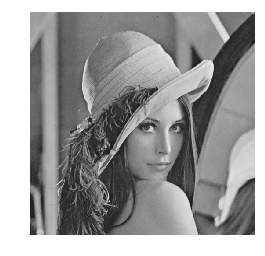

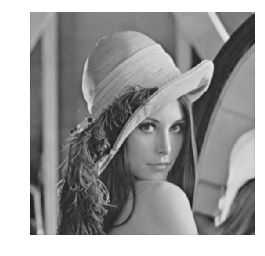

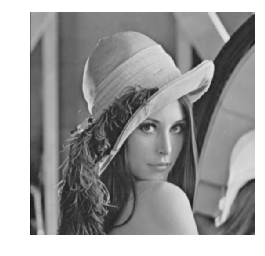

In [11]:
kernel = 1./256*np.array([[1., 4., 6., 4., 1.], [4., 16., 24., 16., 4.],
                          [6., 24., 36., 24., 6.], [4., 16., 24., 16., 4.],
                          [1., 4., 6., 4., 1.]])
out = Conv2D(im, kernel)
out2 = Conv_fn2(im, kernel)

plt.figure
io.imshow(im)
plt.axis('off')

plt.show()

plt.figure
io.imshow(out)
plt.axis('off')
plt.show()

plt.figure
io.imshow(out2)
plt.axis('off')
plt.show()


In [12]:
Gx = np.array([[-1., 0., 1.],[-2., 0., 2.],[-1., 0., 1.]])
Gy = np.array([[-1., -2., -1.],[0., 0., 0.],[1., 2., 1.]])

Outx = Conv2D(im, Gx)
Outy = Conv2D(im, Gy)

Out2x = Conv_fn2(im, Gx)
Out2y = Conv_fn2(im, Gy)



/home/lemaitre/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
Out_mag = np.sqrt(Outx**2 + Outy**2)
Out_mag = Out_mag/ (np.max(Out_mag))

Out_mag2 = np.sqrt(Out2x**2 + Out2y**2)
Out_mag2 = Out_mag2 / (np.max(Out_mag2))


Out_theta = np.arctan(Outy/Outx)


/home/lemaitre/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide
/home/lemaitre/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


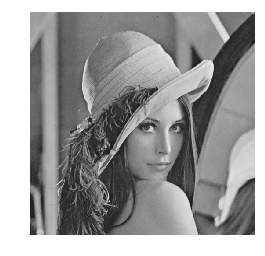

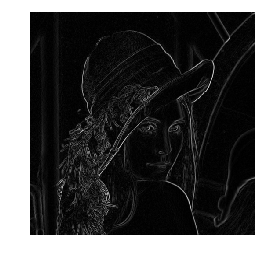

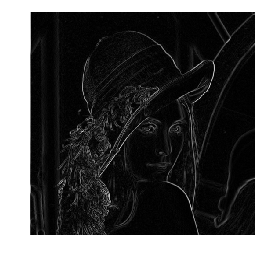

In [14]:

plt.figure
io.imshow(im)
plt.axis('off')
plt.show()

plt.figure
io.imshow(Out_mag)
plt.axis('off')
plt.show()

plt.figure
io.imshow(Out_mag2)
plt.axis('off')
plt.show()

#plt.figure
#plt.imshow(Out_theta, cmap = cm.gray)
#plt.axis('off')
#plt.show()

## Exercise 3 - Character recognition using cross-correlation

**3.1** load `a.png` and `text.png` images and binarized them using [`threshold_otsu`](http://scikit-image.org/docs/dev/api/skimage.filters.html?highlight=filters#skimage.filters.threshold_otsu)

**3.2** Use [`signal.correlate2d`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.signal.correlate2d.html#scipy.signal.correlate2d) from `scipy` to correlate your binarized images.
**Note, signal correspond to the bright pixels within and image (invert your masks)**

**3.3** Find the first 10 characters recognized as `a`.

In [15]:
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage import color

img1 = io.imread(Path.__add__('a.png'))
img2 = io.imread(Path.__add__('text.png'))
img2 = color.rgb2gray(img2)
img1 = color.rgb2gray(img1)

img1_th = threshold_otsu(img1)
print img1_th
mask1  = img1 > img1_th

img2_th = threshold_otsu(img2)
print img2_th
mask2 = img2 > img2_th





0.513671875
0.552734375


In [16]:
from scipy import signal
from scipy import misc

img1 =  abs(1 - img1)
img2 =  abs(1 - img2)
mask1 = abs(1 - mask1)
mask2 = abs(1 - mask2)
N = 10
corr = signal.correlate2d(mask2, mask1, mode='same')
x = np.zeros((N,))
y = np.zeros((N,))
corr_cp = corr.copy()
d = np.where(corr_cp == np.max(corr))
x = d[0]
y = d[1]

#for i in range(0,N):
#    x[i], y[i] = np.where(corr_cp == np.max(corr))
#    corr_cp[x[i]][y[i]] = 0
    
#x = corr.argsort()[-4:]
#print x.shape                        
#y, x = np.unravel_index([corr.argsort()[-4:][::-1], corr.argsort()[::-1][-4:]], corr.shape) # find the match

/home/lemaitre/anaconda/lib/python2.7/site-packages/scikit_image-0.12.dev0-py2.7-linux-x86_64.egg/skimage/io/_plugins/matplotlib_plugin.py:70: UserWarning: Non-standard image type; displaying image with stretched contrast.
  warnings.warn("Non-standard image type; displaying image with "
/home/lemaitre/anaconda/lib/python2.7/site-packages/scikit_image-0.12.dev0-py2.7-linux-x86_64.egg/skimage/io/_plugins/matplotlib_plugin.py:73: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warnings.warn("Low image dynamic range; displaying image with "
/home/lemaitre/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


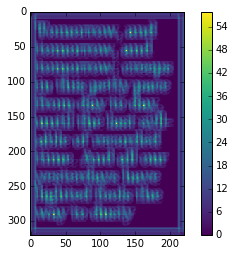

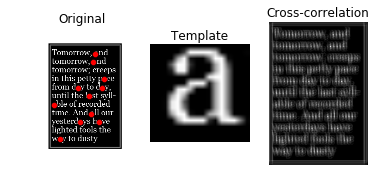

In [17]:
plt.figure()
io.imshow(corr)



fig, (ax_orig, ax_template, ax_corr) = plt.subplots(1, 3)
ax_orig.imshow(img2, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_template.imshow(img1, cmap='gray')
ax_template.set_title('Template')
ax_template.set_axis_off()
ax_corr.imshow(corr, cmap='gray')
ax_corr.set_title('Cross-correlation')
ax_corr.set_axis_off()
ax_orig.plot(y, x, 'ro')
fig.show()